In [1]:
#!/home/neil.lu/.conda/envs/ringdown/bin/python
# coding: utf-8

import matplotlib.pyplot as pl
import numpy as np
import re
import qnm_filter
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import scipy as sp
import argparse
from natsort import natsorted
import glob
import astropy.units as u
import time
import os
import sys
import matplotlib
mplparams = {
    'text.usetex': True,
    'axes.linewidth': 1,
    'axes.grid': False,
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 26,
    'figure.figsize': (10,8),
    'legend.fontsize':20,
    'legend.handlelength':3
}
matplotlib.rcParams.update(mplparams)

In [2]:
def load_data(filename):
    likelihood_data = np.loadtxt(str(directory+filename))
    evidence = sp.special.logsumexp(likelihood_data)
    
    # Metadata
    f = open(directory+filename)
    header = f.readline()[2:]

    time_patt = r"time=(\d+\.\d+)"
    time_offset = float(re.search(time_patt, header).group(1))

    evidence_patt = r"evidence=(-\d+\.\d+)"
    evidence = float(re.search(evidence_patt, header).group(1))

    filter_patt = r"model_list=(.*?)\,"
    filter_str = re.search(filter_patt, header).group(1)

    credible_patt = r"credible=(-\d+\.\d+)"
    credible = float(re.search(credible_patt, header).group(1))

    chi_patt = r"chi_bounds=\((\d+\.\d+)_(\d+\.\d+)\)"
    chi_match = re.search(chi_patt, header)
    chi_lower = float(chi_match.group(1))
    chi_upper = float(chi_match.group(2))

    mass_patt = r"mass_bounds=\((\d+)_(\d+)\)"
    mass_match = re.search(mass_patt, header)
    mass_lower = float(mass_match.group(1))
    mass_upper = float(mass_match.group(2))

    massspace = np.linspace(mass_lower, mass_upper, likelihood_data.shape[1], endpoint=False)
    chispace = np.linspace(chi_lower, chi_upper, likelihood_data.shape[0], endpoint=False)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, np.diff(massspace)[0], np.diff(chispace)[0])
    
    return likelihood_data, evidence, time_offset, filter_str, credible, \
            chi_lower, chi_upper, mass_lower, mass_upper, \
            massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi

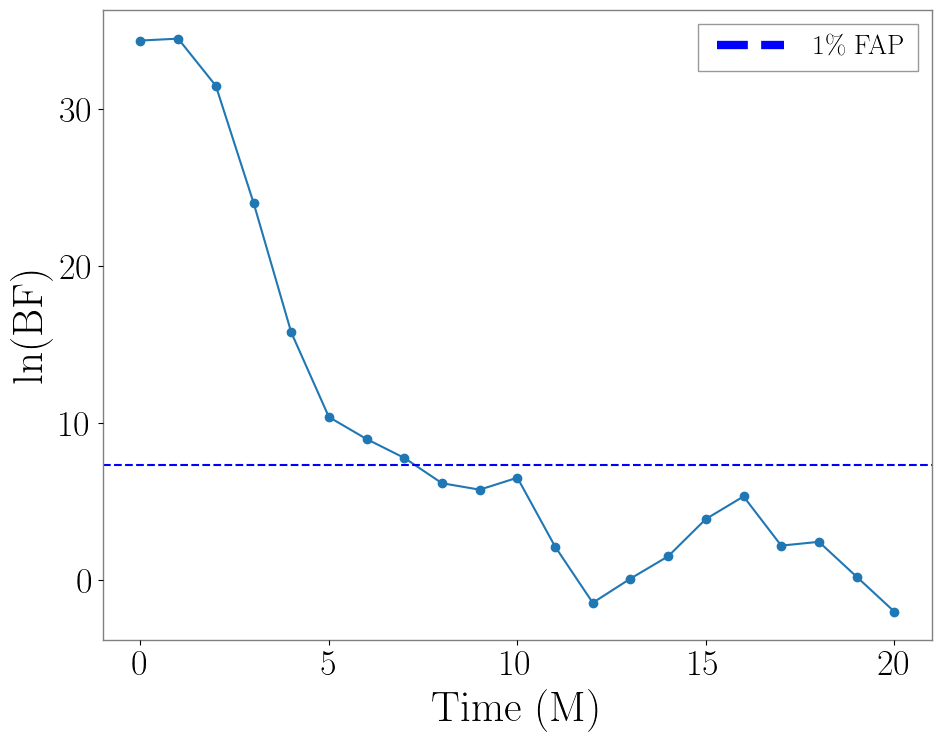

In [3]:
time_arr, evidence_arr, ref_evidence = np.loadtxt("results/0305_injection.txt")
pl.plot(time_arr, evidence_arr - ref_evidence, marker='o')

pl.xlabel("Time (M)")
pl.ylabel("ln(BF)")
pl.axhline(7.37, ls='--', c='b', label='1\% FAP')
pl.legend()
pl.tight_layout()
pl.savefig("plots/0305-220+221:220.pdf")

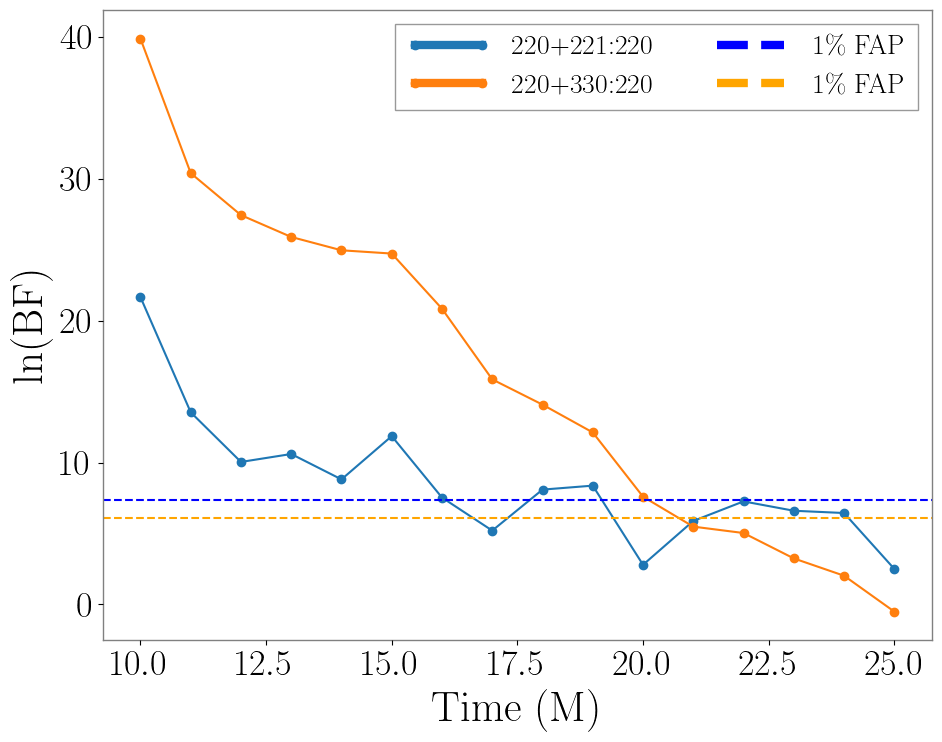

In [7]:
time_arr, evidence220_221, evidence220_330, evidence220 = np.loadtxt("results/1107_injection.txt")
pl.plot(time_arr, evidence220_221 - evidence220, marker='o', label='220+221:220')
pl.plot(time_arr, evidence220_330 - evidence220, marker='o', label='220+330:220')

pl.xlabel("Time (M)")
pl.ylabel("ln(BF)")
pl.axhline(7.37, ls='--', c='b', label='1\% FAP')
pl.axhline(6.09, ls='--', c='orange', label='1\% FAP')
pl.legend(ncol=2)
pl.tight_layout()
pl.savefig("plots/1107-BF_curve.pdf")